In [1]:

import os

# This forces OpenMP to use 1 single thread, which is needed to
# prevent contention between multiple process.
os.environ['OMP_NUM_THREADS'] = '1'
# Tell numpy to only use one core.
os.environ['MKL_NUM_THREADS'] = '1'


import multiprocessing as mp
import sys
from absl import flags

import numpy as np
import torch
from torch.optim.lr_scheduler import MultiStepLR

FLAGS = flags.FLAGS

flags.DEFINE_integer('board_size', 9, 'Board size for Go.')
flags.DEFINE_float('komi', 7.5, 'Komi rule for Go.')
flags.DEFINE_integer(
    'num_stack',
    8,
    'Stack N previous states, the state is an image of N x 2 + 1 binary planes.',
)
flags.DEFINE_integer('num_res_blocks', 10, 'Number of residual blocks in the neural network.')
flags.DEFINE_integer('num_filters_resnet', 128, 'Number of filters for the conv2d layers in the neural network.')
flags.DEFINE_integer(
    'num_fc_units',
    128,
    'Number of hidden units in the linear layer of the neural network.',
)

flags.DEFINE_integer(
    'num_simulations',
    200,
    'Number of simulations per MCTS search, this applies to both self-play and evaluation processes.',
)

flags.DEFINE_integer(
    'num_parallel',
    8,
    'Number of leaves to collect before using the neural network to evaluate the positions during MCTS search,'
    '1 means no parallel search.',
)
flags.DEFINE_float(
    'c_puct_base',
    19652,
    'Exploration constants balancing priors vs. search values. Original paper use 19652',
)
flags.DEFINE_float(
    'c_puct_init',
    1.25,
    'Exploration constants balancing priors vs. search values. Original paper use 1.25',
)

flags.DEFINE_float(
    'default_rating',
    1500,
    'Default elo rating, change to the rating (for black) from last checkpoint when resume training.',
)
flags.DEFINE_string(
    'logs_dir',
    './logs/go/9x9/alphago_series',
    'Path to save statistics for self-play, training, and evaluation.',
)
flags.DEFINE_string('log_level', 'INFO', '')
flags.DEFINE_integer('seed', 1, 'Seed the runtime.')
# Initialize flags
FLAGS(sys.argv, known_only = True)

os.environ['BOARD_SIZE'] = str(FLAGS.board_size)

In [ ]:
from alpha_zero.envs.go import GoEnv
from alpha_zero.core.pipeline import (
    set_seed,
    maybe_create_dir,
)
from alpha_zero.core.multi_game import run_tournament
from alpha_zero.core.quantum_net import QuantumAlphaZeroNet
from alpha_zero.core.network import AlphaZeroNet
from alpha_zero.utils.util import extract_args_from_flags_dict, create_logger

In [3]:
agent_configs = [
    {
        'name': 'Agent_1',
        'num_filters': 128,
        'max_depth': 3,
        'branching_width': 3,
        'beam_width': 1,
        'num_fc_units':128,
        'num_search':3,
        'load_chkpt' : './checkpoints/go/9x9/quantum/d_3s_3br_3f_128be_1/training_steps_11500.ckpt'
    },

    {
        'name': 'Agent_2',
        'num_filters': 128,
        'max_depth': 5,
        'branching_width': 3,
        'beam_width': 1,
        'num_fc_units':128,
        'num_search':2,
        'load_chkpt' : './checkpoints/go/9x9/quantum/d_5s_2br_3f_128be_1/training_steps_10500.ckpt'
    },

    {
        'name': 'Agent_3',
        'num_filters': 84,
        'max_depth': 2,
        'branching_width': 3,
        'beam_width': 1,
        'num_fc_units':128,
        'num_search':5,
        'load_chkpt' : './checkpoints/go/9x9/quantum/d_2s_5br_3f_84be_1/training_steps_11500.ckpt'
    },
    {
        'name': 'Agent_4',
        'num_filters': 128,
        'max_depth': 10,
        'branching_width': 3,
        'beam_width': 1,
        'num_fc_units':128,
        'num_search':1,
        'load_chkpt' : './checkpoints/go/9x9/quantum/d_10s_1br_3f_128be_1/training_steps_11000.ckpt'
    },
    {
        'name': 'Agent_5',
        'num_filters': 256,
        'max_depth': 10,
        'branching_width': 3,
        'beam_width': 1,
        'num_fc_units':128,
        'num_search':1,
        'load_chkpt' : './checkpoints/go/9x9/quantum/d_10s_1br_3f_256be_1/training_steps_7200.ckpt'
    },
    {
        'name': 'Agent_6',
        'num_filters': 236,
        'max_depth': 10,
        'branching_width': 3,
        'beam_width': 1,
        'num_fc_units':128,
        'num_search': 1,
        'load_chkpt' : './checkpoints/go/9x9/quantum/d_10s_1br_3f_236be_1/training_steps_6800.ckpt'
    },
    {
        'name': 'Agent_7',
        'num_filters': 72,
        'max_depth': 1,
        'branching_width': 3,
        'beam_width': 1,
        'num_fc_units':128,
        'num_search': 10,
        'load_chkpt' : './checkpoints/go/9x9/quantum/d_1s_10br_3f_72be_1/training_steps_25000.ckpt'


    },
]


In [4]:
def env_builder():
        return GoEnv(komi=FLAGS.komi, num_stack=FLAGS.num_stack)
eval_env = env_builder()

input_shape = eval_env.observation_space.shape
num_actions = eval_env.action_space.n

# Initialize agents
Agents = []
for config in agent_configs:
    agent = QuantumAlphaZeroNet(
        input_shape,
        num_actions,
        config['num_filters'],
        config['max_depth'],
        config['branching_width'],
        config['beam_width'],
        config['num_fc_units'],
        config['num_search'],
    )
    Agents.append(agent)

resnet_agent = AlphaZeroNet(
            input_shape,
            num_actions,
            FLAGS.num_res_blocks,
            FLAGS.num_filters_resnet,
            FLAGS.num_fc_units,
        )
resnet_chkpt = './checkpoints/go/9x9/resnets/network/training_steps_5500.ckpt'

In [5]:
# Initialize agents with metadata
agents = {
    "ResNet": {
        "network": resnet_agent,
        "elo_rating": 1500,  # Initial Elo rating
        "checkpoint": resnet_chkpt,
        "wins": 0,
        "lost": 0
    }
}

# Add QuantumAlphaZeroNet agents
for config, agent in zip(agent_configs, Agents):
    agents[config["name"]] = {
        "network": agent,
        "elo_rating": 1500,  # Initial Elo rating
        "checkpoint": config["load_chkpt"],
        "wins": 0,
        "lost":0
    }


In [ ]:
set_seed(FLAGS.seed)

logger = create_logger(FLAGS.log_level)

logger.info(extract_args_from_flags_dict(FLAGS.flag_values_dict()))


In [ ]:
if torch.cuda.is_available():
    learner_device = torch.device('cuda')

run_tournament(
    seed = FLAGS.seed,
    agents = agents,
    env = eval_env,
    device = learner_device,
    num_games = 100,
    num_simulations = FLAGS.num_simulations,
    num_parallel = FLAGS.num_parallel,
    c_puct_base = FLAGS.c_puct_base,
    c_puct_init = FLAGS.c_puct_init,
    default_rating = FLAGS.default_rating,
    log_level = FLAGS.log_level,
    logs_dir = FLAGS.logs_dir,

)

In [ ]:
elo_ratings = [round(agent_data['elo_rating'],2) for agent_data in agents.values()]
print(elo_ratings)

In [18]:
params = ['2.99M', '2.57M', '1.73M', '1.96M', '0.88M', '3.2M', '2.7M', '1.99M']

for agent_config, param in zip(agent_configs, params):
    agent_config.pop('load_chkpt', None)  # Remove load_checkpoint if it exists
    agent_config.pop('num_fc_units', None)
    agent_config['total_params'] = param

In [19]:
for agent_config, param in zip(agent_configs, params):
    agent_config.pop('total_parameters', None)  # Remove load_checkpoint if it exists


In [20]:
resnet_agent = {
    'name': 'ResNet',
    'num_res_blocks': 10,
    'num_filters_resnet': 128,
}
agent_configs.insert(0, resnet_agent)


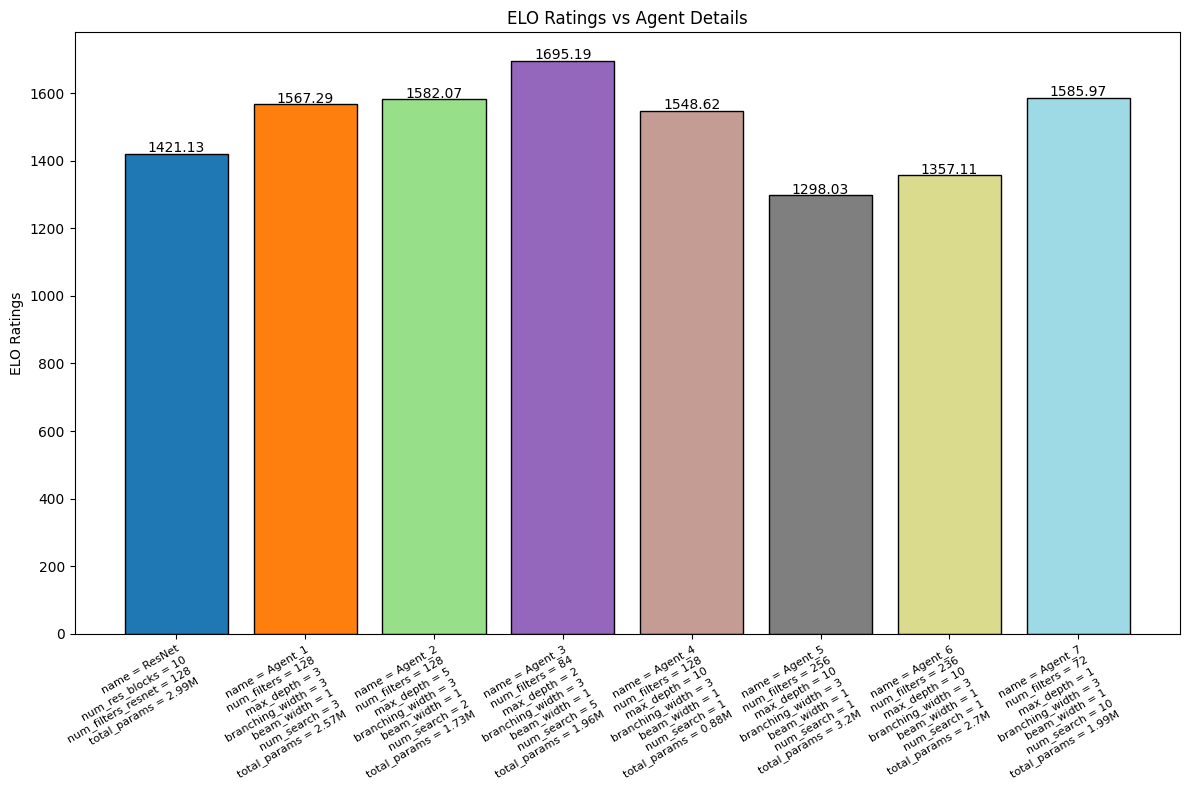

In [27]:
import matplotlib.pyplot as plt


# Prepare data for plotting
def format_agent_details(agent):
    """Format the dictionary into a multiline string for x-axis labels."""
    details = [f"{key} = {value}" for key, value in agent.items()]
    return "\n".join(details)

x_labels = [format_agent_details(agent) for agent in agent_configs]  # Format as multiline strings

y_values = elo_ratings

colors = plt.cm.tab20(np.linspace(0, 1, len(x_labels)))

# Plot the bar diagram
plt.figure(figsize=(12, 8))
plt.bar(range(len(x_labels)), y_values, color=colors, edgecolor='black')

# Add Elo values above the bars
for i, rating in enumerate(elo_ratings):
    plt.text(i, rating + 5, f"{rating:.2f}", ha="center", fontsize=10)
plt.ylabel("ELO Ratings")
plt.title("ELO Ratings vs Agent Details")
plt.xticks(range(len(x_labels)), x_labels, rotation=30, ha='right', fontsize=8, wrap=True)
plt.tight_layout()
plt.show()